In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

DATA_PATH="../Data_Entry_2017.csv"
IMAGE_PATH="../images/"
xray_df = pd.read_csv(DATA_PATH)


images={os.path.basename(x):x for x in glob(os.path.join(IMAGE_PATH,'image*','*','*.png'))}

xray_df['Path']=xray_df['Image Index'].map(images.get)
print (len(images),xray_df.shape)
print (xray_df.head())

112120 (112120, 13)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
0                        0.143

In [2]:
xray_df['Finding Labels'] = xray_df['Finding Labels'].map(lambda x:x.replace('No Finding',''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x:x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print (len(all_labels),all_labels)

for c_label in all_labels:
    xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0.0)
    
print (xray_df.sample(5))

                       

14 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
            Image Index          Finding Labels  Follow-up #  Patient ID  \
37591  00009894_000.png                                    0        9894   
80113  00019684_002.png                                    2       19684   
83566  00020505_008.png  Infiltration|Pneumonia            8       20505   
59954  00014798_013.png            Infiltration           13       14798   
29858  00007762_015.png   Effusion|Infiltration           15        7762   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
37591           64              F            PA                 2402     2991   
80113           52              M            PA                 2882     2916   
83566           52              M            AP                 3056     2544   
59954           23        

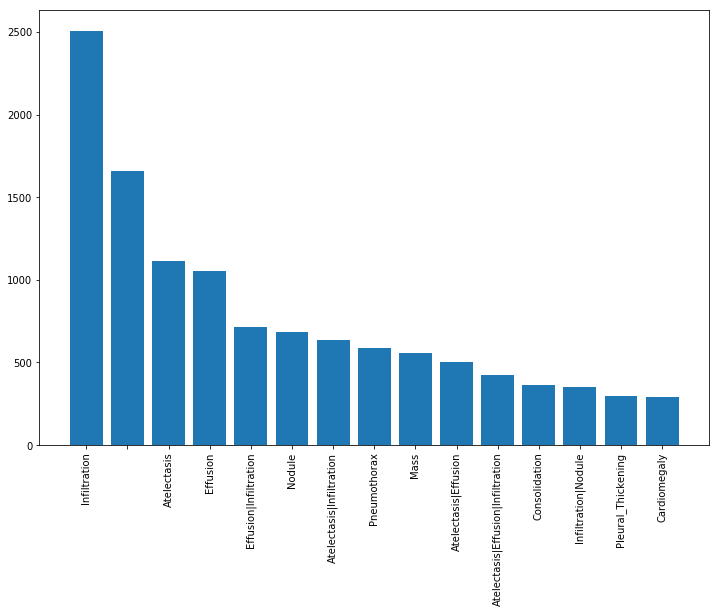

In [3]:
#we create a mini dataset for GAN

sample_weight_mini = xray_df['Finding Labels'].map(lambda x:len(x.split('|')) if len(x)>0 else 0.0).values +1e-1
sample_weight_mini/=sample_weight_mini.sum()
xray_df_mini=xray_df.sample(20000,weights=sample_weight_mini)

label_count_mini = xray_df_mini['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_count_mini))+0.5, label_count_mini)
ax1.set_xticks(np.arange(len(label_count_mini))+0.5)
_ = ax1.set_xticklabels(label_count_mini.index, rotation = 90)

In [23]:
#we create a hdf5 file of our mini dataset which will be used later
import h5py as h5py
from tqdm import tqdm

def write_df_as_hdf(out_path,out_df,compression='gzip'):
    with h5py.File(out_path,'w') as h:
        for k, arr_dict in tqdm(out_df.to_dict().items()):
            try:
                s_data = np.stack(arr_dict.values(),0)
                try:
                    h.create_dataset(k, data = s_data,compression = compression)
                except TypeError as e:
                    try:
                        h.create_dataset(k,data=s_data.astype(np.string_),compression=compression)
                    except TypeError as e2:
                        print ("%s could not be added to hdf5,%s" %(k,repr(e),repr(e2)))
                    
            except ValueError as e:
                print ('%s could not be created,%s' %(k,repr(e)))
                all_shape = [np.shape(x) for x in arr_dict.values()]
                warn('Input shapes :{}'.format(all_shape))
                

In [24]:
write_df_as_hdf('chest_xray.h5',xray_df_mini)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.77it/s]


In [25]:
#reading the mini dataset
with h5py.File('chest_xray.h5','r') as h_data:
    for c_key in h_data.keys():
        print (c_key,h_data[c_key].shape,h_data[c_key].dtype)

Atelectasis (20000,) float64
Cardiomegaly (20000,) float64
Consolidation (20000,) float64
Edema (20000,) float64
Effusion (20000,) float64
Emphysema (20000,) float64
Fibrosis (20000,) float64
Finding Labels (20000,) |S100
Follow-up # (20000,) int32
Height] (20000,) int32
Hernia (20000,) float64
Image Index (20000,) |S16
Infiltration (20000,) float64
Mass (20000,) float64
Nodule (20000,) float64
OriginalImagePixelSpacing[x (20000,) float64
OriginalImage[Width (20000,) int32
Path (20000,) |S44
Patient Age (20000,) int32
Patient Gender (20000,) |S1
Patient ID (20000,) int32
Pleural_Thickening (20000,) float64
Pneumonia (20000,) float64
Pneumothorax (20000,) float64
Unnamed: 11 (20000,) float64
View Position (20000,) |S2
y] (20000,) float64


c:\python35\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


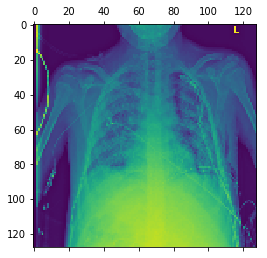

In [29]:
# preprocessing images using CLAHE algorithm as in kaggle kernel
from skimage.transform import resize
from cv2 import createCLAHE,imread
OUT_DIM = (128, 128)
clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def imread_and_normalize(im_path):
    img_data = np.mean(imread(im_path), 2).astype(np.uint8)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    return np.expand_dims(n_img, -1)


test_img = imread_and_normalize(xray_df_mini['Path'].values[0])
plt.matshow(test_img[:,:,0])


In [30]:
out_image_arr = np.zeros((xray_df_mini.shape[0],) + OUT_DIM+(1,),dtype=np.uint8)
if False:
    out_image_arr = np.random.uniform(0,255,size = (xray_df_mini.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)

In [31]:
for i,c_path in enumerate(tqdm(xray_df_mini['Path'].values)):
    out_image_arr[i] = imread_and_normalize(c_path)

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]c:\python35\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [30:13<00:00, 11.03it/s]


In [32]:
with h5py.File('chest_xray.h5','a') as h5_data:
    h5_data.create_dataset('images',data = out_image_arr,compression=None)
with h5py.File('chest_xray.h5','r') as h5_data:
    for c_key in h5_data.keys():
        print (c_key,h5_data[c_key].shape,h5_data[c_key].dtype)

Atelectasis (20000,) float64
Cardiomegaly (20000,) float64
Consolidation (20000,) float64
Edema (20000,) float64
Effusion (20000,) float64
Emphysema (20000,) float64
Fibrosis (20000,) float64
Finding Labels (20000,) |S100
Follow-up # (20000,) int32
Height] (20000,) int32
Hernia (20000,) float64
Image Index (20000,) |S16
Infiltration (20000,) float64
Mass (20000,) float64
Nodule (20000,) float64
OriginalImagePixelSpacing[x (20000,) float64
OriginalImage[Width (20000,) int32
Path (20000,) |S44
Patient Age (20000,) int32
Patient Gender (20000,) |S1
Patient ID (20000,) int32
Pleural_Thickening (20000,) float64
Pneumonia (20000,) float64
Pneumothorax (20000,) float64
Unnamed: 11 (20000,) float64
View Position (20000,) |S2
images (20000, 128, 128, 1) uint8
y] (20000,) float64


In [32]:
min_cases =1000
all_labels = [c_label for c_label in all_labels if xray_df[c_label].sum() > min_cases]
print ('Clean Labels-{}'.format(len(all_labels)),all_labels)

Clean Labels-13 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Sampling 50000 data

In [43]:
sample_weights = xray_df['Finding Labels'].map(lambda x:len(x.split('|')) if len(x)>0 else 0).values +4e-2
sample_weights /= sample_weights.sum()

print (sample_weights)
xray_df = xray_df.sample(50000,weights = sample_weights)

print (xray_df['Finding Labels'].value_counts()[:15])
print (xray_df[all_labels].values.shape)

[1.34889754e-05 3.94293126e-05 1.34889754e-05 ... 5.18806744e-07
 5.18806744e-07 5.18806744e-07]
Infiltration                7967
                            3832
Atelectasis                 3493
Effusion                    3302
Nodule                      2260
Pneumothorax                1848
Mass                        1779
Effusion|Infiltration       1548
Atelectasis|Infiltration    1315
Atelectasis|Effusion        1133
Consolidation               1086
Pleural_Thickening           948
Cardiomegaly                 923
Infiltration|Nodule          809
Emphysema                    749
Name: Finding Labels, dtype: int64
(50000, 13)


In [44]:
xray_df['Disease_Vec'] = xray_df.apply(lambda x:[x[all_labels].values],1).map(lambda x:x[0])
print (xray_df['Disease_Vec'])

68029     [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
27413     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
83996     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...
103495    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
35685     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
3921      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
90675     [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
106142    [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...
57244     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
13331     [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...
20127     [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
38124     [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
28089     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...
60412     [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
85602     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
26200     [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
41201     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0,

In [45]:
from sklearn.model_selection import train_test_split
train_df, validation_df = train_test_split(xray_df , test_size =0.2)
print (train_df.shape,validation_df.shape)

(40000, 28) (10000, 28)


In [65]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE =(96,96)
img_gen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization =True,
                            horizontal_flip=True,height_shift_range=0.05,width_shift_range=0.1,rotation_range=5,
                            shear_range=0.1,zoom_range=0.15,fill_mode='reflect')


In [66]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [67]:
train_gen = flow_from_dataframe(img_gen, train_df, path_col ='Path', y_col = 'Disease_Vec',target_size=IMG_SIZE,
                               color_mode='grayscale',batch_size=32)
valid_gen = flow_from_dataframe(img_gen, validation_df,path_col = 'Path',y_col ='Disease_Vec',target_size=IMG_SIZE,
                               color_mode='grayscale',batch_size=256)
test_x,test_y = next(flow_from_dataframe(img_gen,validation_df,path_col='Path',y_col='Disease_Vec',target_size=IMG_SIZE,color_mode='grayscale',
                                        batch_size=1024))

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 40000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


In [68]:
t_x, t_y = next(train_gen)
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_96 (Model)    (None, 3, 3, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

In [71]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
weight_path = 'my_model_weight_{}.hdf5'.format('xray_50000_(96,96)')
checkpoint=ModelCheckpoint(weight_path,monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]


In [72]:
multi_disease_model.fit_generator(train_gen,steps_per_epoch=100,validation_data=(test_x,test_y),epochs=5,callbacks=callbacks_list)

Epoch 1/5
100/100 [==============================] - 159s 2s/step - loss: 0.3700 - binary_accuracy: 0.8750 - mean_absolute_error: 0.1875 - val_loss: 0.3635 - val_binary_accuracy: 0.8855 - val_mean_absolute_error: 0.1875

Epoch 00001: val_loss improved from inf to 0.36349, saving model to my_model_weight_xray_50000_(96,96).hdf5
Epoch 2/5
100/100 [==============================] - 158s 2s/step - loss: 0.3472 - binary_accuracy: 0.8792 - mean_absolute_error: 0.1882 - val_loss: 0.3202 - val_binary_accuracy: 0.8855 - val_mean_absolute_error: 0.1924

Epoch 00002: val_loss improved from 0.36349 to 0.32022, saving model to my_model_weight_xray_50000_(96,96).hdf5
Epoch 3/5
100/100 [==============================] - 144s 1s/step - loss: 0.3332 - binary_accuracy: 0.8804 - mean_absolute_error: 0.1884 - val_loss: 0.3338 - val_binary_accuracy: 0.8850 - val_mean_absolute_error: 0.1709

Epoch 00003: val_loss did not improve
Epoch 4/5
100/100 [==============================] - 139s 1s/step - loss: 0.327

Atelectasis: Dx: 20.70%, PDx: 21.75%
Cardiomegaly: Dx: 4.98%, PDx: 3.43%
Consolidation: Dx: 7.03%, PDx: 7.51%
Edema: Dx: 4.00%, PDx: 2.73%
Effusion: Dx: 25.20%, PDx: 22.42%
Emphysema: Dx: 4.98%, PDx: 3.72%
Fibrosis: Dx: 2.73%, PDx: 3.46%
Infiltration: Dx: 34.47%, PDx: 34.78%
Mass: Dx: 11.43%, PDx: 11.96%
Nodule: Dx: 11.72%, PDx: 12.07%
Pleural_Thickening: Dx: 7.71%, PDx: 4.94%
Pneumonia: Dx: 2.93%, PDx: 1.78%
Pneumothorax: Dx: 10.94%, PDx: 5.67%


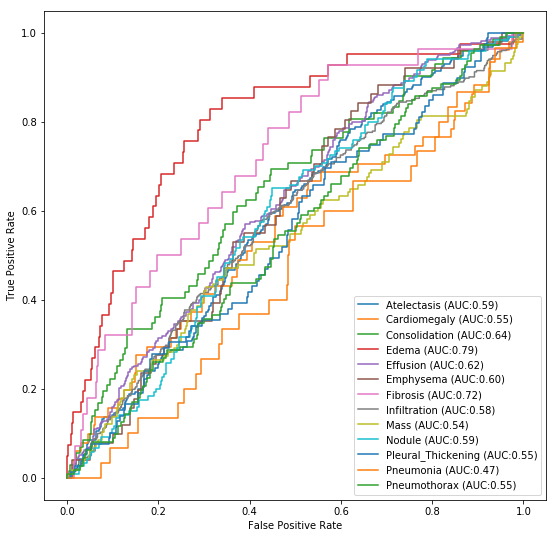

In [74]:
#load weights and predict
multi_disease_model.load_weights(weight_path)
pred_y = multi_disease_model.predict(test_x,batch_size=32)
#How often does our model predict certain diseases occuring
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_y,0), 
                                     100*np.mean(test_y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))
    
#Visualizing ROC curve and AUC values
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_y[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')